# Artificial Neural Networks and Deep Learning

---
## Homework 2: Image segmentation of Mars' stones
## Team: The Backpropagators
Arianna Procaccio, Francesco Buccoliero, Kai-Xi Matteo Chen, Luca Capoferri

ariii, frbuccoliero, kaiximatteoc, luke01

246843, 245498, 245523, 259617


## ⚙️ Import Libraries

In [1]:
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import albumentations as A
import numpy as np
import tensorflow as tf

/opt/homebrew/Caskroom/miniconda/base/envs/anndl/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# ⚙️ Settings

In [ ]:
seed = 666

train_ratio = 0.85
validation_ratio = 0.10
test_ratio = 0.05

IMG_SIZE = (64, 128)
NUM_CLASSES = 5

running_on = "local" # local | colab | kaggle

quick_run = True # If true skips the early plotting stuff

model_name = 'ASPP' # U_NET | U_NET_XCEPTION | UWNet | ASPP | ROCKSEG | TURKEYSEG | GROUP_NORM_UNET | LIGHT4MARS

# Training schedule
training_schedule = [
  # Second run over augmented data
  {
    "augmentation" : True,
    "augmentation_repetition": 2,
    #"enlarge_dataset_with_custom_np_ds": True,
    "include_non_augmented": True,
    "epochs": 1000,
    "batch_size": 16,
    "lr": 1e-4,
    "opt_name": "AdamW", # SGD | Adam | AdamW | Lion | Ranger
  }
]

# Exponential decay
opt_exp_decay_rate: float | None = None 
opt_decay_epoch_delta = 7 # Number of epochs between each decay, if above None is not used

USE_CLASS_WEIGHTS: bool | list[int,int,int,int,int] = False # If true will use class weights for loss function, if false will use all ones, if list will use that list

loss_fn = 'combined_loss' # sparse_categorical_crossentropy | boundary_loss | dice_loss | combined_loss

FREE_MODEL = False # If true the model is deleted from memory after being dumped to file

model_filename_override = None # If not None will load the model from this file and perform inference

DATASET_PATH_LOCAL = "dataset.npz"
DATASET_PATH_COLAB = "/content/drive/MyDrive/Colab Notebooks/dataset.npz"
DATASET_PATH_KAGGLE = "/kaggle/input/dataset-h2/dataset.npz"

OUTLIER_MASK_LOCAL = "outlier_mask.npy"
OUTLIER_MASK_COLAB = "/content/drive/MyDrive/Colab Notebooks/outlier_mask.npy"
OUTLIER_MASK_KAGGLE = "/kaggle/input/dataset-h2/outlier_mask.npy"

In [ ]:
# Define here the Albumentation pipeline to be used for augmentation

def build_augmentation():
  transform = A.Compose([
          A.RandomRotate90(p=0.7),  # Random 90-degree rotation
          A.HorizontalFlip(p=0.7),  # Horizontal flip for diverse texture representation
          A.VerticalFlip(p=0.7),  # Vertical flip to simulate different orientations
          A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),  # Adjust brightness and contrast
          A.GaussianBlur(blur_limit=3, p=0.7),  # Add blur to simulate camera effects
          A.CoarseDropout(max_holes=4, max_height=16, max_width=16, p=0.7),  # Randomly occlude parts of the image
          A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.7),  # Random shifts, scales, and rotations
          A.ElasticTransform(alpha=1, sigma=50, p=0.7),
          A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.7),
          A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.7),
          A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], p=1),  # Resize for consistent input size
      ])

  # # For Matteo, do not delete
  # transform = A.Compose([
  #  A.RandomRotate90(p=0.7),  # Random 90-degree rotation
  #  A.HorizontalFlip(p=0.7),  # Horizontal flip for diverse texture representation
  #  A.VerticalFlip(p=0.7),  # Vertical flip to simulate different orientations
  #  A.ElasticTransform(alpha=50, sigma=50, p=0.7),
  #  A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.7),
  #  A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], p=1),  # Resize for consistent input size
  # ])
  
  return transform

In [ ]:
# A custom augmentation for some specific targets (e.g. images with a lot of background)
def build_augmentation_bg():
  transform = A.Compose([
      A.RandomRotate90(p=0.5),  # Random 90-degree rotation
      A.HorizontalFlip(p=0.5),  # Horizontal flip for diverse texture representation
      A.VerticalFlip(p=0.5),  # Vertical flip to simulate different orientations
      A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], p=1),  # Resize for consistent input size
    ])
  return transform

In [12]:
# Loading configurations based on the given settings
assert train_ratio + validation_ratio + test_ratio == 1

np.random.seed(seed)
tf.random.set_seed(seed)

DATASET_PATH = DATASET_PATH_LOCAL if running_on == "local" else DATASET_PATH_COLAB if running_on == "colab" else DATASET_PATH_KAGGLE
OUTLIER_MASK = OUTLIER_MASK_LOCAL if running_on == "local" else OUTLIER_MASK_COLAB if running_on == "colab" else OUTLIER_MASK_KAGGLE

data = np.load(DATASET_PATH)
outlier_mask_template = np.load(OUTLIER_MASK) # discovered by hand

## ⏳ Load, inspect and prepare the data

In [13]:
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

hidden_X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test hidden X shape: {hidden_X_test.shape}")

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255
X_train = X_train.astype(np.float32)
hidden_X_test = hidden_X_test[..., np.newaxis] / 255
hidden_X_test = hidden_X_test.astype(np.float32)

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

# Split train and validation
validation_size = int(X_train.shape[0] * validation_ratio)

indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

# Define train and validation indices
split_indices = [int(X_train.shape[0] * train_ratio), int(X_train.shape[0] * (train_ratio + validation_ratio))]

X_train, X_val, X_test = np.split(X_train, split_indices)
y_train, y_val, y_test = np.split(y_train, split_indices)

print("======= BEFORE REMOVING OUTLIERS =======")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")

# Outliers share the mask
train_outliers_indices = [i for i, img in enumerate(y_train) if not np.array_equal(img, outlier_mask_template)]
val_outliers_indices = [i for i, img in enumerate(y_val) if not np.array_equal(img, outlier_mask_template)]
test_outliers_indices = [i for i, img in enumerate(y_test) if not np.array_equal(img, outlier_mask_template)]
print(f'Total outliers in train set: {y_train.shape[0] - len(train_outliers_indices)}')
print(f'Total outliers in validation set: {y_val.shape[0] - len(val_outliers_indices)}')
print(f'Total outliers in test set: {y_test.shape[0] - len(test_outliers_indices)}')

# Remove outlier from train and validation set
X_train = X_train[train_outliers_indices]
y_train = y_train[train_outliers_indices]
X_val = X_val[val_outliers_indices]
y_val = y_val[val_outliers_indices]
X_test = X_test[test_outliers_indices]
y_test = y_test[test_outliers_indices]

print("======= AFTER REMOVING OUTLIERS =======")
print(f'Updated train dataset size: {X_train.shape}')
print(f'Updated validation dataset size: {X_val.shape}')
print(f'Updated test dataset size: {X_test.shape}')

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test hidden X shape: (10022, 64, 128)
Input shape: (64, 128, 1)
Number of classes: 5
======= BEFORE REMOVING OUTLIERS =======
Training X shape: (2222, 64, 128, 1)
Training y shape: (2222, 64, 128)
Validation X shape: (262, 64, 128, 1)
Validation y shape: (262, 64, 128)
Test X shape: (131, 64, 128, 1)
Test y shape: (131, 64, 128)
Total outliers in train set: 89
Total outliers in validation set: 16
Total outliers in test set: 5
======= AFTER REMOVING OUTLIERS =======
Updated train dataset size: (2133, 64, 128, 1)
Updated validation dataset size: (246, 64, 128, 1)
Updated test dataset size: (126, 64, 128, 1)


In [ ]:
# Retrieve images with a lot of label labels
def retrieve_imgs_of_label(X, y, bg_label_min_percentage=0.9, label=0):
  tot_pixels = IMG_SIZE[0] * IMG_SIZE[1]
  imgs = []
  labels = []
  # Count pixels for each class
  for label_image, img in zip(y, X):
    unique, counts = np.unique(label_image, return_counts=True)
    for u, c in zip(unique, counts):
      if int(u) == label and c / tot_pixels >= bg_label_min_percentage:
        imgs.append(img)
        labels.append(label_image)
  return np.array(imgs), np.array(labels)


In [ ]:
# Retrieve noisy labelled images
noisy_images = {i: () for i in range(5)}
for k in noisy_images.keys():
  imgs, labels = retrieve_imgs_of_label(X_train, y_train, bg_label_min_percentage=0.85, label=k)
  noisy_images[k] = (imgs, labels)
  print('Retrieved images:', noisy_images[k][0].shape[0], 'with at least 75% of label', k)

Retrieved images: 184 with at least 75% of label 0
Retrieved images: 584 with at least 75% of label 1
Retrieved images: 279 with at least 75% of label 2
Retrieved images: 234 with at least 75% of label 3
Retrieved images: 0 with at least 75% of label 4


In [ ]:
# Plot the data. The number of images being displayed are rows X cols
def plot(data, mask=None, num_images=10, rows=4, cols=8, num_cls=5, colors=None):
  # Reshape if needed (e.g., remove channel dimension for grayscale images)
  if data.shape[-1] == 1:  # Grayscale case
    data = data.squeeze(axis=-1)  # Remove channel dimension
  
  if mask is None:
    # Plot settings
    _, axes = plt.subplots(rows, cols, figsize=(12, 6))  # Adjust figure size as needed
  
    # Display images
    for i, ax in enumerate(axes.flat):
      if i < len(data):  # Check if there are enough images
        ax.imshow(data[i], cmap='gray' if len(data[i].shape) == 2 else None)
        ax.axis('off')  # Hide axes
      else:
        ax.axis('off')  # Hide any empty subplot
  
    plt.tight_layout()
    plt.show()
  else:

    # Define custom colors for each class
    import matplotlib.colors as mcolors
    if num_cls == 2:
      class_colors = ["blue", "purple"] if colors is None else colors
      bounds = [0,0.5,1.5]
    elif num_classes == 5:
      class_colors = ["purple", "blue", "green", "orange", "yellow"] if colors is None else colors
      bounds = [0,0.5,1.5,2.5,3.5,4.5]
    else:
      raise RuntimeError('Not impl')
    cmap = mcolors.ListedColormap(class_colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Define normalization to map class values to the color map
    bounds = np.arange(num_cls + 1) - 0.5  # Create boundaries for each class
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    num_samples = num_images  # Number of images to display
    if num_samples < 4:
      num_samples = 4

    # Plot settings
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 2))

    for i in range(num_samples):
      # Original image
      axes[i, 0].imshow(data[i], cmap="gray")
      axes[i, 0].set_title(f"Image {i+1}")
      axes[i, 0].axis("off")

      # Corresponding mask
      axes[i, 1].imshow(mask[i], cmap=cmap, norm=norm)  # Adjust cmap as needed
      axes[i, 1].set_title(f"Mask {i+1}")
      axes[i, 1].axis("off")
    # Add a colorbar
    cbar = fig.colorbar(
      plt.cm.ScalarMappable(cmap=cmap, norm=norm),
      ax=axes[:, 1],  # Align the colorbar with the mask columns
      orientation="vertical",
      fraction=0.02,
      pad=0.04
    )
    cbar.set_ticks(np.arange(num_cls))  # Set tick locations
    cbar.set_ticklabels([f"Class {i}" for i in range(num_cls)])  # Set tick labels

    #plt.tight_layout()
    plt.show()

In [ ]:
if not quick_run:
  plot(X_train, rows=10, cols=8)

In [ ]:
# An additional check: you should not see any outlier
if not quick_run:
  plot(X_val, mask=y_val, num_images=100)

In [ ]:
def check_class_distribution(label_dataset, num_classes):
  # Initialize counts for each class
  class_counts = np.zeros(num_classes)

  # Count pixels for each class
  for label_image in label_dataset:
      unique, counts = np.unique(label_image, return_counts=True)
      for u, c in zip(unique, counts):
          class_counts[u] += c

  # Normalize counts (percentage)
  total_pixels = np.sum(class_counts)
  class_distribution = class_counts / total_pixels * 100

  # Print and visualize
  print("Class Distribution (% of pixels):")
  for i in range(num_classes):
      print(f"Class {i}: {class_distribution[i]:.2f}%")
  
  if not quick_run:
    # Plot class distribution
    plt.bar(range(num_classes), class_distribution, tick_label=[f"Class {i}" for i in range(num_classes)])
    plt.xlabel("Classes")
    plt.ylabel("Percentage of Pixels")
    plt.title("Class Distribution")
    plt.show()
  
  return class_distribution

def get_class_weights(class_distribution):
  # Convert percentage to class probabilities
  class_probabilities = np.array(class_distribution) / 100.0

  # Calculate class weights (inverse of class probability)
  class_weights = 1.0 / class_probabilities

  # Normalize weights (optional, you can skip normalization if desired)
  max_weight = np.max(class_weights)
  class_weights = class_weights / max_weight  # Normalize to have the maximum weight = 1

  return {i:w for i,w in enumerate(class_weights)}

# Check for 5 classes (class IDs: 0-4)
class_distribution = check_class_distribution([e.astype(np.int8) for e in y_train], num_classes=num_classes)

if type(USE_CLASS_WEIGHTS) == bool:
  if USE_CLASS_WEIGHTS:
    class_weights = get_class_weights(class_distribution)
  else:
    class_weights = {i: 1.0/num_classes for i in range(num_classes)}
else:
  class_weights = {i: w for i, w in enumerate(USE_CLASS_WEIGHTS)}

print('Class weights:', class_weights)

Class Distribution (% of pixels):
Class 0: 24.21%
Class 1: 34.56%
Class 2: 23.05%
Class 3: 18.05%
Class 4: 0.13%
Class weights: {0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2}


In [ ]:
# `concat_and_shuffle_aug_with_no_aug` will double the X_train size
# `remove_bg` will set all the bg pixels to dark
# `augmentation_repetition` will concatenate n times the augmented dataset by applying the same `augmentations` fn. Useful for augmentation pipeline with probability activations
def get_dataset(X, y, batch_size=32, augmentations=None, augmentation_repetition=1, **kwargs):

  def resize_img_and_mask(img, mask):
    input_img = tf.image.resize(img, IMG_SIZE)
    input_img = tf.cast(input_img, tf.float32)

    # Resize needs at least 3 dims, add a dummy one
    if kwargs.get('one_hot', False):
      mask = tf.cast(mask, tf.int32)
      target_img = tf.one_hot(mask, depth=num_classes, axis=-1)
    else:
      target_img = tf.expand_dims(mask, axis=-1)
    # Nearest-neighbor is essential for resizing segmentation masks because it preserves the discrete class labels (e.g., 0, 1, 2) without introducing unintended values due to interpolation
    target_img = tf.image.resize(target_img, IMG_SIZE, method="nearest")
    target_img = tf.cast(target_img, tf.int32) # Consider lower integers

    return input_img, target_img

  def remove_background(image, mask, background_label=0):
    background_mask = (mask == background_label)
    image[background_mask] = 0  # Set to black
    return image, mask

  def apply_augmentation_np():
    X_a = []
    y_a = []
    for i, m in zip(X, y):
      aug_img, aug_mask = augmentations(i, m)
      if kwargs.get('remove_bg', False):
        aug_img, aug_mask = remove_background(aug_img, aug_mask)
      X_a.append(aug_img)  
      y_a.append(aug_mask)  
    return np.array(X_a), np.array(y_a)
  
  if kwargs.get('remove_bg', False):
    X_a = []
    y_a = []
    for i, m in zip(X, y):
      aug_img, aug_mask = remove_background(i, m)
      X_a.append(aug_img)
      y_a.append(aug_mask)
    X = np.array(X_a)
    y = np.array(y_a)

  # Apply augmentations before converting to dataset (this will be serial I think but we avoid type conversions as A works on np arrays)
  if augmentations is not None:
    X_a, y_a = apply_augmentation_np()
    dataset = tf.data.Dataset.from_tensor_slices((X_a, y_a))
    if augmentation_repetition > 1:
      for i in range(augmentation_repetition-1):
        X_a, y_a = apply_augmentation_np()
        dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((X_a, y_a)))
    add_len = 0
    if kwargs.get('additional_ds_concat', None):
      # Optimistic
      add_len = len(kwargs['additional_ds_concat'])
      for pair in kwargs['additional_ds_concat']:
        print('concatenating additional ds')
        images, labels = pair
        images = images.astype(np.float32)
        dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((images, labels)))
    if kwargs.get('concat_and_shuffle_aug_with_no_aug', False):
      dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((X, y)))
      dataset = dataset.shuffle(seed=seed, buffer_size=X.shape[0] * (augmentation_repetition+1+add_len))
    else:
      dataset = dataset.shuffle(seed=seed, buffer_size=X.shape[0] * (augmentation_repetition+add_len))

  else:
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    add_len = 0
    if kwargs.get('additional_ds_concat', None):
      # Optimistic
      add_len = len(kwargs['additional_ds_concat'])
      for pair in kwargs['additional_ds_concat']:
        print('concatenating additional ds')
        images, labels = pair
        images = images.astype(np.float32)
        dataset = dataset.concatenate(tf.data.Dataset.from_tensor_slices((images, labels)))
    dataset = dataset.shuffle(seed=seed, buffer_size=X.shape[0] * (add_len+1))

  dataset = dataset.map(resize_img_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
# Enlarge dataset containing images provided in the inputs
def get_enlarged_dataset(imgs, labels, aug_fn, repetitions=2, unbatch=True, np_ds=True):
  def apply_aug(img, mask):
    transform = aug_fn()
    transformed = transform(image=img, mask=mask)
    return transformed["image"], transformed["mask"]
  if np_ds:
    X_a = []
    y_a = []
    for _ in range(repetitions):
      for i, m in zip(imgs, labels):
        aug_img, aug_mask = apply_aug(i, m)
        X_a.append(aug_img)  
        y_a.append(aug_mask)  
    return np.array(X_a), np.array(y_a)
  else:
    enlarged_bg_dataset = get_dataset(imgs, labels, augmentations=apply_aug, augmentation_repetition=repetitions)
    # We unbatch as this will be concatenated with other ds
    if unbatch:
      ds = enlarged_bg_dataset.unbatch()
    return ds

In [ ]:
# Try the enlarged bg images dataset as example
if not quick_run:
  N = 10
  a, b =  get_enlarged_dataset(noisy_images[0][0][:N], noisy_images[0][1][:N], build_augmentation_bg, np_ds=True)
  print(a.shape, b.shape)
  plot(a, mask=b, num_images=N)


## 🎲 Define training configuration

In [ ]:

def compute_signed_distance_map(mask):
    
    # Calcola la distanza esterna (distanza dai bordi del foreground)
    inv_mask = 1 - mask
    dist_out = tf.cast(tf.nn.relu(tf.image.sobel_edges(inv_mask)), tf.float32)

    # Calcola la distanza interna (distanza dai bordi del background)
    dist_in = tf.cast(tf.nn.relu(tf.image.sobel_edges(mask)), tf.float32)

    # Combina le distanze in un unico gradiente
    dx_out, dy_out = dist_out[..., 0], dist_out[..., 1]
    dx_in, dy_in = dist_in[..., 0], dist_in[..., 1]

    dist_out_combined = tf.sqrt(tf.square(dx_out) + tf.square(dy_out))
    dist_in_combined = tf.sqrt(tf.square(dx_in) + tf.square(dy_in))

    # Signed Distance Map: negativo all'interno, positivo all'esterno
    sdm = dist_out_combined - dist_in_combined
    return sdm

def boundary_loss(y_true, y_pred):
    # Calcola la Signed Distance Map
    sdm = compute_signed_distance_map(y_true)
    
    # Normalizza le previsioni
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Calcola la boundary loss
    loss = tf.reduce_mean(tf.abs(sdm * (y_true - y_pred)))
    
    return loss

def dice_loss(y_true, y_pred, smooth=1e-6):
  # Convert y_true to one-hot if needed
  # TODO: should we retrieve the argmax and use 1 channels instead of 5?
  if y_true.shape[-1] != y_pred.shape[-1]:
      y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1])
  
  # Compute Dice Loss per class
  intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
  union = tf.reduce_sum(y_true + y_pred, axis=(1, 2))
  dice = (2. * intersection + smooth) / (union + smooth)
  
  # Average Dice Loss over all classes and batch
  dice_loss = 1 - tf.reduce_mean(dice)
  
  return dice_loss


def combined_loss(y_true, y_pred):

        loss_sparse = tfk.losses.sparse_categorical_crossentropy(y_true, y_pred)
        loss_dice = dice_loss(y_true, y_pred)
    
        if y_true.shape[-1] != y_pred.shape[-1]:
            y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1])
        focal_loss = tfk.losses.CategoricalFocalCrossentropy() 
    
        loss_focal = focal_loss(y_true, y_pred)
        loss_boundary = boundary_loss(y_true, y_pred)

        # Create class masks
        class_ids = tf.argmax(y_true, axis=-1)  # Find the class labels (integer format)
        class_0_mask = tf.cast(tf.equal(class_ids, 0), tf.float32)
        #class_1_mask = tf.cast(tf.equal(class_ids, 1), tf.float32)
        class_4_mask = tf.cast(tf.equal(class_ids, 4), tf.float32)
        other_classes_mask = 1.0 - class_0_mask - class_4_mask  # Remainder classes
    
        # Apply specific losses for each class
        loss_focal = loss_focal * class_0_mask
        loss_dice = loss_dice * class_4_mask
        loss_sparse = loss_sparse * other_classes_mask

        return loss_focal + loss_dice + loss_sparse + 0.1 * loss_boundary

def get_loss():
  if loss_fn == 'sparse_categorical_crossentropy':
    return tfk.losses.SparseCategoricalCrossentropy()
  elif loss_fn == 'boundary_loss':
    return boundary_loss
  elif loss_fn == 'dice_loss':
    return dice_loss
  elif loss_fn == 'combined_loss':
    return combined_loss
  else:
    raise ValueError(f"Loss function {loss_fn} not recognized")


In [ ]:
# Visualization callback
category_map = {
  0: 0, # Background,
  1: 1, # Soil,
  2: 2, # Bedrock,
  3: 3, # Sand,
  4: 4, # Big Rock,
}

def apply_category_mapping(label):
  """
  Apply category mapping to labels.
  """
  print("Label dtype before mapping:", label.dtype)
  keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
  vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
  table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=0
  )
  return table.lookup(label)

def create_segmentation_colormap(num_classes):
  """
  Create a linear colormap using a predefined palette.
  Uses 'viridis' as default because it is perceptually uniform
  and works well for colorblindness.
  """
  return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
  """
  Apply the colormap to a label.
  """
  # Ensure label is 2D
  label = np.squeeze(label)

  if colormap is None:
    num_classes = len(np.unique(label))
    colormap = create_segmentation_colormap(num_classes)

  # Apply the colormap
  colored = colormap[label.astype(int)]

  return colored
  
class VizCallback(tf.keras.callbacks.Callback):
  def __init__(self, image, label, frequency=5):
    super().__init__()
    self.image = image
    self.label = tf.cast(tf.convert_to_tensor(label), tf.int32) 
    self.frequency = frequency

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
      image, label = self.image, self.label
      label = apply_category_mapping(label)
      image = tf.expand_dims(image, 0)
      pred = self.model.predict(image, verbose=0)
      y_pred = tf.math.argmax(pred, axis=-1)
      y_pred = y_pred.numpy()

      # Create colormap
      num_classes = NUM_CLASSES
      colormap = create_segmentation_colormap(num_classes)

      plt.figure(figsize=(16, 4))

      # Input image
      plt.subplot(1, 3, 1)
      plt.imshow(image[0],cmap='gray')
      plt.title("Input Image")
      plt.axis('off')

      # Ground truth
      plt.subplot(1, 3, 2)
      colored_label = apply_colormap(label.numpy(), colormap)
      plt.imshow(colored_label)
      plt.title("Ground Truth Mask")
      plt.axis('off')

      # Prediction
      plt.subplot(1, 3, 3)
      colored_pred = apply_colormap(y_pred[0], colormap)
      plt.imshow(colored_pred)
      plt.title("Predicted Mask")
      plt.axis('off')

      plt.tight_layout()
      plt.show()
      plt.close()

In [ ]:
# Define fitting callbacks. Comment out from dict the unwanted ones
val_mask = tf.expand_dims(y_val[0], axis=-1)
val_mask = tf.image.resize(val_mask, [IMG_SIZE[0], IMG_SIZE[1]], method="nearest")
val_img = tf.image.resize(X_val[0], [IMG_SIZE[0], IMG_SIZE[1]])
viz_callback = VizCallback(val_img, val_mask)
model_fit_callbacks = {
  'ReduceLROnPlateau': tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6, verbose=1),
  'EarlyStopping': tfk.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience=50, restore_best_weights=True, verbose=1),
  'Viz_callback' : viz_callback
}

def get_callbacks():
  return [i for i in model_fit_callbacks.values()]

2024-12-11 09:51:09.709943: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-11 09:51:09.710020: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-11 09:51:09.710026: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-11 09:51:09.710052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 09:51:09.710073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 🛠️ Define model, augmentation and utils builders

In [ ]:
def apply_augmentation(img, mask):
  transform = build_augmentation()
  transformed = transform(image=img, mask=mask)
  return transformed["image"], transformed["mask"]


In [ ]:
# Try the augmented dataset
if not quick_run:
  N = 2
  ds = get_dataset(X_train[:N], y_train[:N], augmentations=apply_augmentation, augmentation_repetition=4, concat_and_shuffle_aug_with_no_aug=True)

  for batch in ds.take(1):
    a, b = batch
    plot(a.numpy(), b.numpy(), num_images=N * 5) # use N * (augmentation_repetition+1) as `concat_and_shuffle_aug_with_no_aug` is True 
    break


In [ ]:
def build_classifier_xception(input_shape, num_cls, augmentation=None):
    inputs = tfkl.Input(shape=input_shape)

    if augmentation is not None:
        x = augmentation(inputs)
    else:
        x = inputs

    # Entry block
    x = tfkl.Conv2D(128, 3, strides=2, padding="same")(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = tfkl.ReLU()(x)
        x = tfkl.SeparableConv2D(size, 3, padding="same")(x)
        x = tfkl.BatchNormalization()(x)

        x = tfkl.ReLU()(x)
        x = tfkl.SeparableConv2D(size, 3, padding="same")(x)
        x = tfkl.BatchNormalization()(x)

        x = tfkl.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tfkl.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tfkl.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tfkl.SeparableConv2D(1024, 3, padding="same")(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.GlobalAveragePooling2D()(x)
    if num_cls == 2:
        units = 1
    else:
        units = num_cls

    x = tfkl.Dropout(0.25)(x)
    outputs = tfkl.Dense(units, activation='sigmoid' if units == 1 else 'softmax')(x)

    return tfk.Model(inputs=inputs, outputs=outputs, name='Xception')

In [ ]:
def build_custom_classifier(input_shape, num_cls, augmentation=None):
  assert(num_cls >= 2)
  
  # Define the input layer
  input_layer = tfkl.Input(shape=input_shape, name='Input')

  # Apply optional data augmentation, then first convolutional layer
  if augmentation == None:
      x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
  else:
      x = augmentation(input_layer)
      x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(x)

  # Apply activation and pooling after the first convolution
  x = tfkl.ReLU(name='relu0')(x)
  x = tfkl.MaxPooling2D(name='mp0')(x)

  # Apply second convolutional layer, activation, and pooling
  #x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(x)
  #x = tfkl.ReLU(name='relu1')(x)
  #x = tfkl.MaxPooling2D(name='mp1')(x)

  # Apply third convolutional layer, activation, and pooling
  x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
  x = tfkl.ReLU(name='relu2')(x)
  x = tfkl.MaxPooling2D(name='mp2')(x)

  # Apply fourth convolutional layer, activation, and pooling
  x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv3')(x)
  x = tfkl.ReLU(name='relu3')(x)
  x = tfkl.MaxPooling2D(name='mp3')(x)

  x = tfkl.Flatten(name='flatten')(x)
  x = tfkl.Dense(128, activation='relu', name='dense1')(x)
  x = tfkl.Dropout(0.2, name='drop1')(x)

  # Define the output layer
  output_layer = tfkl.Dense(num_cls if num_cls > 2 else 1, activation='sigmoid' if num_cls == 2 else 'softmax', name='Output')(x)

  # Create the model
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

  return model

In [ ]:
def build_classifier(name: str, input_shape: tuple, num_cls: int, augmentation=None):
  if name == 'cnn':
    return build_custom_classifier(input_shape=input_shape, num_cls=num_cls, augmentation=augmentation)
  elif name == 'xception':
    return build_classifier_xception(input_shape=input_shape, num_cls=num_cls, augmentation=augmentation)
  else:
    raise ValueError('Not impl')

In [ ]:
def build_U_NET(img_size: tuple[int, int, int], num_classes):
  def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

  input_layer = tfkl.Input(shape=img_size, name='input_layer')

  # Downsampling path
  down_block_1 = unet_block(input_layer, 32, name='down_block1_')
  d1 = tfkl.MaxPooling2D()(down_block_1)

  down_block_2 = unet_block(d1, 64, name='down_block2_')
  d2 = tfkl.MaxPooling2D()(down_block_2)

  # Bottleneck
  bottleneck = unet_block(d2, 128, name='bottleneck')

  # Upsampling path
  u1 = tfkl.UpSampling2D()(bottleneck)
  u1 = tfkl.Concatenate()([u1, down_block_2])
  u1 = unet_block(u1, 64, name='up_block1_')

  u2 = tfkl.UpSampling2D()(u1)
  u2 = tfkl.Concatenate()([u2, down_block_1])
  u2 = unet_block(u2, 32, name='up_block2_')

  # Output Layer
  if num_classes==1:
    output_layer = tfkl.Conv2D(1, kernel_size=1, padding='same', activation="sigmoid", name='output_layer')(u2)
  else:
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
  return model

In [ ]:
def build_ATTENTION_UW_NET(img_size: tuple[int, int, int], num_classes):
  def attention_block(x, g, inter_channel):
    # theta_x (bs, h, w, inter_channel)
    theta_x = tfkl.Conv2D(inter_channel, [1, 1], strides=[1, 1])(x)
    
    # phi_g (bs, h, w, inter_channel)
    phi_g = tfkl.Conv2D(inter_channel, [1, 1], strides=[1, 1])(g)
    
    # f (bs, h, w, 1)
    f = tfkl.Activation('relu')(tfkl.Add()([theta_x, phi_g]))
    psi_f = tfkl.Conv2D(1, [1, 1], strides=[1, 1])(f)
    
    # sigmoid_psi_f (bs, h, w, 1)
    sigmoid_psi_f = tfkl.Activation('sigmoid')(psi_f)
    
    # rate (bs, h, w, 1)
    rate = tfkl.multiply([x, sigmoid_psi_f])
    
    return rate
  
  # Input
  inputs = tfkl.Input(shape=img_size)
  
  # Encoder Path
  # Block 1
  conv1 = tfkl.Conv2D(64, 3, padding='same')(inputs)
  conv1 = tfkl.BatchNormalization()(conv1)
  conv1 = tfkl.Activation('relu')(conv1)
  conv1 = tfkl.Conv2D(64, 3, padding='same')(conv1)
  conv1 = tfkl.BatchNormalization()(conv1)
  conv1 = tfkl.Activation('relu')(conv1)
  pool1 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv1)
  
  # Block 2
  conv2 = tfkl.Conv2D(128, 3, padding='same')(pool1)
  conv2 = tfkl.BatchNormalization()(conv2)
  conv2 = tfkl.Activation('relu')(conv2)
  conv2 = tfkl.Conv2D(128, 3, padding='same')(conv2)
  conv2 = tfkl.BatchNormalization()(conv2)
  conv2 = tfkl.Activation('relu')(conv2)
  pool2 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv2)
  
  # Block 3
  conv3 = tfkl.Conv2D(256, 3, padding='same')(pool2)
  conv3 = tfkl.BatchNormalization()(conv3)
  conv3 = tfkl.Activation('relu')(conv3)
  conv3 = tfkl.Conv2D(256, 3, padding='same')(conv3)
  conv3 = tfkl.BatchNormalization()(conv3)
  conv3 = tfkl.Activation('relu')(conv3)
  pool3 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv3)
  
  # Block 4
  conv4 = tfkl.Conv2D(512, 3, padding='same')(pool3)
  conv4 = tfkl.BatchNormalization()(conv4)
  conv4 = tfkl.Activation('relu')(conv4)
  conv4 = tfkl.Conv2D(512, 3, padding='same')(conv4)
  conv4 = tfkl.BatchNormalization()(conv4)
  conv4 = tfkl.Activation('relu')(conv4)
  pool4 = tfkl.MaxPooling2D(pool_size=(2, 2))(conv4)
  
  # Bridge
  conv5 = tfkl.Conv2D(1024, 3, padding='same')(pool4)
  conv5 = tfkl.BatchNormalization()(conv5)
  conv5 = tfkl.Activation('relu')(conv5)
  conv5 = tfkl.Conv2D(1024, 3, padding='same')(conv5)
  conv5 = tfkl.BatchNormalization()(conv5)
  conv5 = tfkl.Activation('relu')(conv5)
  
  # Decoder Path with Attention
  # Block 6
  up6 = tfkl.Conv2D(512, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv5))
  up6 = tfkl.BatchNormalization()(up6)
  up6 = tfkl.Activation('relu')(up6)
  
  att6 = attention_block(conv4, up6, inter_channel=256)
  merge6 = tfkl.concatenate([att6, up6], axis=3)
  
  conv6 = tfkl.Conv2D(512, 3, padding='same')(merge6)
  conv6 = tfkl.BatchNormalization()(conv6)
  conv6 = tfkl.Activation('relu')(conv6)
  conv6 = tfkl.Conv2D(512, 3, padding='same')(conv6)
  conv6 = tfkl.BatchNormalization()(conv6)
  conv6 = tfkl.Activation('relu')(conv6)
  
  # Block 7
  up7 = tfkl.Conv2D(256, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv6))
  up7 = tfkl.BatchNormalization()(up7)
  up7 = tfkl.Activation('relu')(up7)
  
  att7 = attention_block(conv3, up7, inter_channel=128)
  merge7 = tfkl.concatenate([att7, up7], axis=3)
  
  conv7 = tfkl.Conv2D(256, 3, padding='same')(merge7)
  conv7 = tfkl.BatchNormalization()(conv7)
  conv7 = tfkl.Activation('relu')(conv7)
  conv7 = tfkl.Conv2D(256, 3, padding='same')(conv7)
  conv7 = tfkl.BatchNormalization()(conv7)
  conv7 = tfkl.Activation('relu')(conv7)
  
  # Block 8
  up8 = tfkl.Conv2D(128, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv7))
  up8 = tfkl.BatchNormalization()(up8)
  up8 = tfkl.Activation('relu')(up8)
  
  att8 = attention_block(conv2, up8, inter_channel=64)
  merge8 = tfkl.concatenate([att8, up8], axis=3)
  
  conv8 = tfkl.Conv2D(128, 3, padding='same')(merge8)
  conv8 = tfkl.BatchNormalization()(conv8)
  conv8 = tfkl.Activation('relu')(conv8)
  conv8 = tfkl.Conv2D(128, 3, padding='same')(conv8)
  conv8 = tfkl.BatchNormalization()(conv8)
  conv8 = tfkl.Activation('relu')(conv8)
  
  # Block 9
  up9 = tfkl.Conv2D(64, 2, padding='same')(tfkl.UpSampling2D(size=(2, 2))(conv8))
  up9 = tfkl.BatchNormalization()(up9)
  up9 = tfkl.Activation('relu')(up9)
  
  att9 = attention_block(conv1, up9, inter_channel=32)
  merge9 = tfkl.concatenate([att9, up9], axis=3)
  
  conv9 = tfkl.Conv2D(64, 3, padding='same')(merge9)
  conv9 = tfkl.BatchNormalization()(conv9)
  conv9 = tfkl.Activation('relu')(conv9)
  conv9 = tfkl.Conv2D(64, 3, padding='same')(conv9)
  conv9 = tfkl.BatchNormalization()(conv9)
  conv9 = tfkl.Activation('relu')(conv9)
  
  # Output
  if num_classes == 1:
    outputs = tfkl.Conv2D(1, 1, activation='sigmoid')(conv9)
  else:
    outputs = tfkl.Conv2D(num_classes, 1, activation='softmax')(conv9)
  
  model = tfk.Model(inputs=inputs, outputs=outputs, name='AttentionUWNet')
  return model

In [ ]:
def build_ASPP_model(img_size: tuple[int, int, int], num_classes: int):
  
  initializer = tf.keras.initializers.HeNormal()
  regularizer = tf.keras.regularizers.l2(1e-4)

  inputs = tfkl.Input(shape=img_size)

  def conv_block(x, filters, kernel_size=(3, 3), activation="relu", batch_norm=True, dropout_rate=0.2):
    x = tfkl.Conv2D(
      filters,
      kernel_size,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    if batch_norm:
      x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation(activation)(x)
    if dropout_rate > 0:
      x = tfkl.SpatialDropout2D(dropout_rate)(x)
    return x

  def encoder_block(x, filters, dropout_rate=0.2):
    x = conv_block(x, filters, dropout_rate=dropout_rate)
    x = conv_block(x, filters, dropout_rate=dropout_rate)
    p = tfkl.MaxPooling2D(2)(x)
    return x, p

  def atrous_spatial_pyramid_pooling(x, dropout_rate=0.3):
    dims = x.shape[1:3]
    pool = tfkl.GlobalAveragePooling2D()(x)
    pool = tfkl.Reshape((1, 1, x.shape[-1]))(pool)
    pool = tfkl.Conv2D(
      256, 
      1, 
      padding="same", 
      kernel_initializer=initializer, 
      kernel_regularizer=regularizer,
    )(pool)
    pool = tfkl.UpSampling2D(size=dims, interpolation="bilinear")(pool)
    pool = tfkl.SpatialDropout2D(dropout_rate)(pool)

    conv_1x1 = tfkl.Conv2D(
      256,
      1,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    atrous_6 = tfkl.Conv2D(
      256,
      3,
      dilation_rate=6,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    atrous_12 = tfkl.Conv2D(
      256,
      3,
      dilation_rate=12,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    atrous_18 = tfkl.Conv2D(
      256,
      3,
      dilation_rate=18,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)

    x = tfkl.Concatenate()([pool, conv_1x1, atrous_6, atrous_12, atrous_18])
    x = tfkl.Conv2D(
      256,
      1,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    x = tfkl.SpatialDropout2D(dropout_rate)(x)
    return x

  def decoder_block(x, skip, filters, dropout_rate=0.2):
    x = tfkl.Conv2DTranspose(
      filters,
      2,
      strides=2,
      padding="same",
      kernel_initializer=initializer,
      kernel_regularizer=regularizer,
    )(x)
    x = tfkl.Concatenate()([x, skip])
    x = conv_block(x, filters, dropout_rate=dropout_rate)
    return x

  # Encoder
  filters = [64, 128, 256, 512]
  skips = []
  x = inputs
  for f in filters:
    skip, x = encoder_block(x, f, dropout_rate=0.2)
    skips.append(skip)

  # Bottleneck with ASPP
  x = conv_block(x, 1024, dropout_rate=0.3)
  x = atrous_spatial_pyramid_pooling(x, dropout_rate=0.3)

  # Decoder
  skips = skips[::-1]
  decoder_filters = [512, 256, 128, 64]
  for skip, f in zip(skips, decoder_filters):
    x = decoder_block(x, skip, f, dropout_rate=0.2)

  # Final convolutional layer
  outputs = tfkl.Conv2D(
    num_classes, 
    1, 
    activation="softmax", 
    kernel_initializer=initializer, 
    kernel_regularizer=regularizer,
  )(x)

  model = tf.keras.Model(inputs, outputs)
  return model

In [ ]:
model_dict = {
  'U_NET': build_U_NET,
  'UWNet': build_ATTENTION_UW_NET,
  'ASPP' : build_ASPP_model,
}

In [ ]:
def fit_model(model, cw=class_weights, data_loader=None, epochs=100, validation_data_loader=None):
  assert(data_loader is not None)
  assert(validation_data_loader is not None)
  fit_history = model.fit(
        data_loader,
        epochs=epochs,
        validation_data=validation_data_loader,
        class_weight=cw,
        callbacks=get_callbacks()
      ).history
  return fit_history

In [ ]:
# Taken from https://github.com/SeanSdahl/RangerOptimizerTensorflow/blob/master/module.py
def build_ranger(lr=1e-3, weight_decay=0.0):
  try:
    import tensorflow_addons as tfa
  except:
    raise Exception("You have to install tensorflow_addons package for Ranger. Please note that this package is available up to tensorflow==2.14")
  def ranger(sync_period=6,
      slow_step_size=0.5,
      learning_rate=lr,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-7,
      weight_decay=weight_decay,
      amsgrad=False,
      sma_threshold=5.0,
      total_steps=0,
      warmup_proportion=0.1,
      min_lr=0.,
      name="Ranger"):
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim
  return ranger()

def get_optimizer(opt, batch_size, lr, **kwargs):
  decay = opt_exp_decay_rate
  if opt == "SGD":
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9 if 'momentum' not in kwargs else kwargs['momentum'])
    if decay is not None:
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate= lr,
          decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
          decay_rate=opt_exp_decay_rate,
          staircase=True
      )
      optimizer.learning_rate = lr_schedule
      print(f'Using {opt} optimizer with exp decay {decay} (momentum = {optimizer.momentum})')
      return optimizer
    else:
      optimizer.learning_rate = lr
      print(f'Using {opt} optimizer (momentum = {optimizer.momentum})')
      return optimizer

  elif opt == "Adam":
    if 'weight_decay' in kwargs:
      optimizer = tf.keras.optimizers.Adam(weight_decay=kwargs['weight_decay'])
    else:
      optimizer = tf.keras.optimizers.Adam()
    if decay is not None:
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=lr,
          decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
          decay_rate=opt_exp_decay_rate,
          staircase=True
      )
      optimizer.learning_rate = lr_schedule
      print(f'Using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}')
      return optimizer
    else:
      optimizer.learning_rate = lr
      print(f'Using {opt} optimizer (weight decay = {optimizer.weight_decay})')
      return optimizer

  elif opt == "AdamW":
    if 'weight_decay' in kwargs:
      optimizer = tf.keras.optimizers.AdamW(weight_decay=kwargs['weight_decay'])
    else:
      optimizer = tf.keras.optimizers.AdamW()
    if decay is not None:
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate= lr,
          decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
          decay_rate=opt_exp_decay_rate,
          staircase=True
      )
      optimizer.learning_rate = lr_schedule
      print(f'Using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}')
      return optimizer
    else:
      optimizer.learning_rate = lr
      print(f'Using {opt} optimizer (weight decay = {optimizer.weight_decay})')
      return optimizer

  elif opt == "Lion":
    if 'weight_decay' in kwargs:
      optimizer = tf.keras.optimizers.Lion(weight_decay=kwargs['weight_decay'])
    else:
      optimizer = tf.keras.optimizers.Lion()
    if decay is not None:
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate= lr,
          decay_steps=opt_decay_epoch_delta * (X_train.shape[0] // batch_size),  # Decay every 7 epochs
          decay_rate=opt_exp_decay_rate,
          staircase=True
      )
      optimizer.learning_rate = lr_schedule
      print(f'Using {opt} optimizer with exp decay of {decay} weight decay = {optimizer.weight_decay}')
      return optimizer
    else:
      optimizer.learning_rate = lr
      print(f'Using {opt} optimizer (weight decay = {optimizer.weight_decay})')
      return optimizer
  elif opt == "Ranger":
    optimizer = build_ranger(lr=lr, weight_decay=0.0 if 'weight_decay' not in kwargs else kwargs['weight_decay'])
    if decay is not None:
      raise RuntimeError("Not supported")
    else:
      optimizer.learning_rate = lr
      print(f'Uusing {opt} optimizer')
      return optimizer
  print(f"Starting learning rate: {lr} and batch size: {batch_size}")

In [ ]:
def display_model(model, force=False):
  if not quick_run or force:
    # Display a summary of the model architecture
    model.summary(expand_nested=True)
    # Display model architecture with layer shapes and trainable parameters
    tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)
  else:
    # Just print the total parameters
    print(f"Total parameters: {model.count_params()/1e6:.2f}M")

## 🧗🏻‍♂️ Train and save noisy-wellsegmented classifier

In [38]:
classifier_batch_size = 64
classifier_epochs = 500

In [39]:
TOT_PIXELS = IMG_SIZE[0] * IMG_SIZE[1]

In [ ]:
def format_data_for_binary_classifier(X: np.ndarray, y: np.ndarray, threshold=0.85):
  NOISY = 0
  SEGMENTED = 1
  assert(X.shape[0] == y.shape[0])
  labels = []
  for _, label in zip(X, y):
      unique, counts = np.unique(label, return_counts=True)
      f = False
      for u, c in zip(unique, counts):
        if c / TOT_PIXELS >= threshold: 
          labels.append(NOISY)
          f = True
      if not f:
        labels.append(SEGMENTED)
  return X, np.array(labels)

[0 0 1 0]


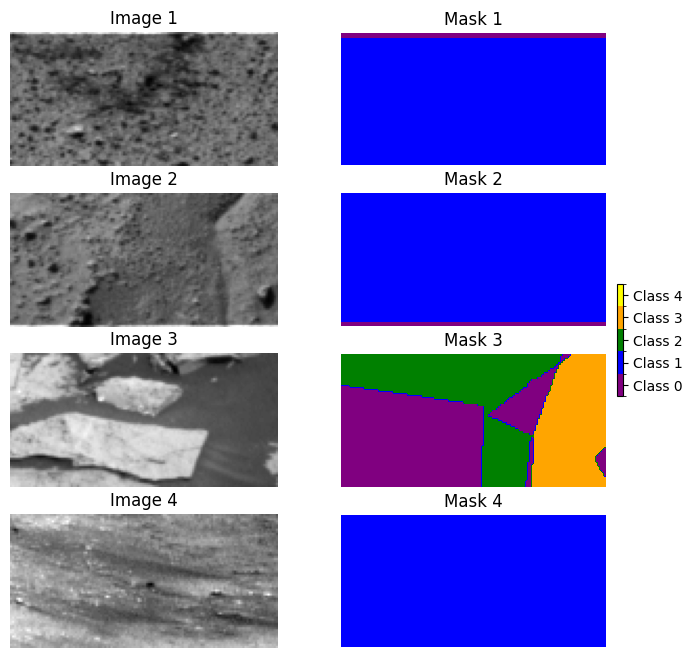

In [41]:
N = 4
# Test
a, b = format_data_for_binary_classifier(X_train[:N], y_train[:N])
print(b)
plot(a, mask=y_train[:N], num_images=N)

In [42]:
# Produce data for classifier
X_train_classifier, y_train_classifier = format_data_for_binary_classifier(X_train, y_train)
X_val_classifier, y_val_classifier = format_data_for_binary_classifier(X_val, y_val)
X_test_classifier, y_test_classifier = format_data_for_binary_classifier(X_test, y_test)

In [ ]:
augmentation = tf.keras.Sequential([
  #tfkl.RandomTranslation(0.1, 0.1),                        # Randomly translate images by ±10% in x and y
  #tfkl.RandomZoom(0.2),  # Zoom (20%)
  tfkl.RandomFlip("horizontal"),  # Horizontal flip
  tfkl.RandomRotation(0.15),  # Rotation (15%)
  #tfkl.RandomFlip("vertical"),  # Vertical flip
  #tfkl.RandomBrightness(0.2),  # Brightness range
], name='augmentations')

In [44]:
model = build_classifier('cnn', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1), num_cls=2, augmentation=augmentation)
display_model(model, force=True)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 64, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentations (Sequential)      │ (None, 64, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_flip (RandomFlip)   │ (None, 64, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_rotation            │ (None, 64, 128, 1)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 64, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu0 (ReLU)                    │ (None, 64, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp0 (MaxPooling2D)              │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp2 (MaxPooling2D)              │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (ReLU)                    │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp3 (MaxPooling2D)              │ (None, 8, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,081 (8.35 MB)

 Trainable params: 2,190,081 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adamW',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]


In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train_classifier,
    y=y_train_classifier,
    batch_size=classifier_batch_size,
    epochs=classifier_epochs,
    validation_data=(X_val_classifier, y_val_classifier),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/500


2024-12-11 09:51:18.906762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5524 - loss: 0.6823 - val_accuracy: 0.6260 - val_loss: 0.6584
Epoch 2/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5849 - loss: 0.6749 - val_accuracy: 0.6260 - val_loss: 0.6649
Epoch 3/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5829 - loss: 0.6713 - val_accuracy: 0.6301 - val_loss: 0.6534
Epoch 4/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5861 - loss: 0.6667 - val_accuracy: 0.6301 - val_loss: 0.6647
Epoch 5/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5850 - loss: 0.6727 - val_accuracy: 0.6260 - val_loss: 0.6461
Epoch 6/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5846 - loss: 0.6576 - val_accuracy: 0.6260 - val_loss: 0.6670
Epoch 7/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5763 - loss: 0.6833 - val_accuracy: 0.6260 - val_loss: 0.6555
Epoch 8/500
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5916 - loss: 0.6677 - val_accuracy: 0.6301 - val_l

In [47]:
model.save(f'binary-cnn{final_val_accuracy}.keras')

In [ ]:
def plot_cnn_training(history):
  # Plot the training
  plt.figure(figsize=(15,5))
  plt.plot(history['loss'], alpha=.3, color='#ff7f0e', label='Trainig loss', linestyle='--')
  plt.plot(history['val_loss'], label='Validation loss', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Binary Crossentropy')
  plt.grid(alpha=.3)
  
  plt.figure(figsize=(15,5))
  plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', label='Training Loss', linestyle='--')
  plt.plot(history['val_accuracy'], label='Validation loss', alpha=.8, color='#ff7f0e')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)
  
  plt.show()

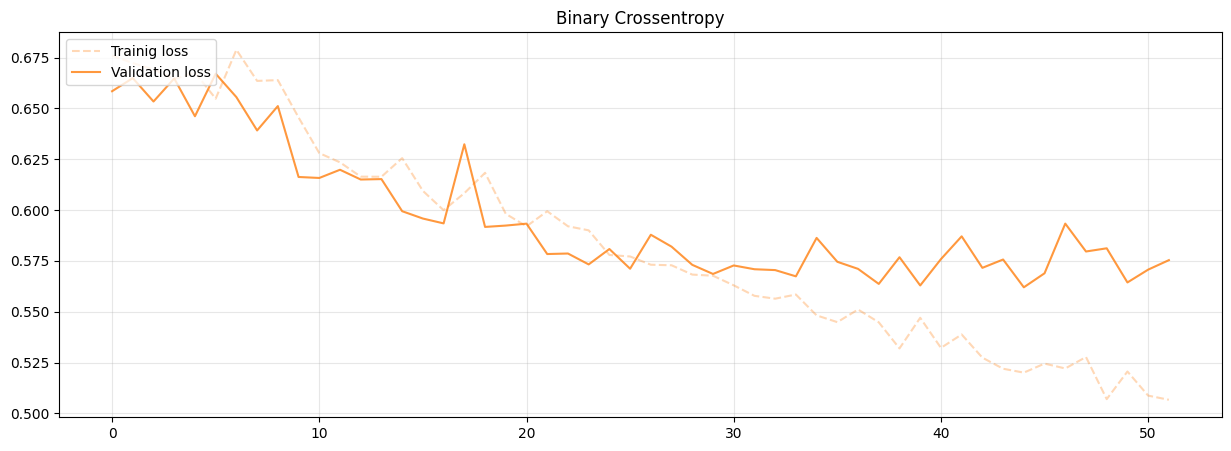

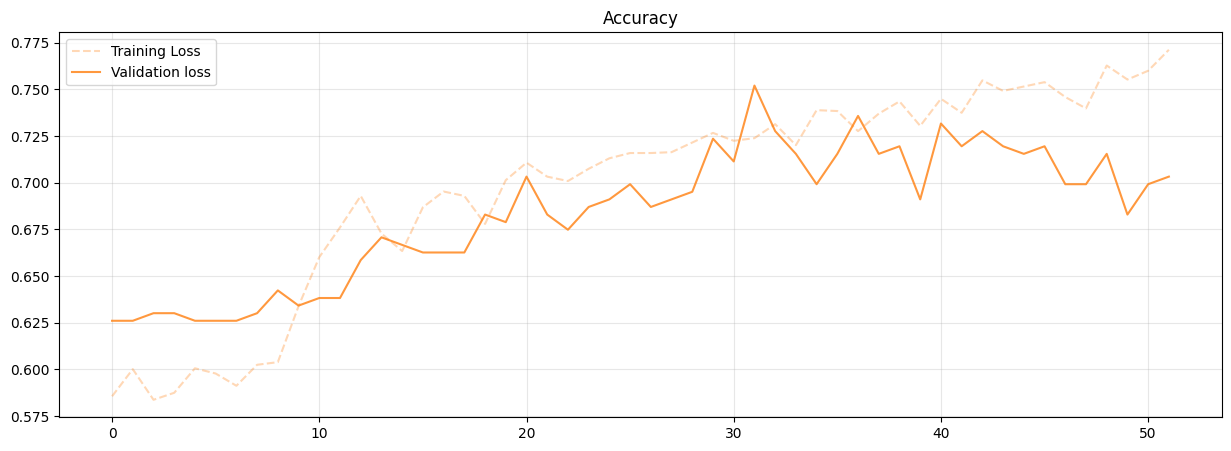

In [49]:
plot_cnn_training(history)

In [ ]:
def plot_cnn_prediction(m, X, y):
  from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
  import seaborn as sns
  predictions = m.predict(X, verbose=1)
  print("Predictions Shape:", predictions.shape)
  pred_classes = (predictions > 0.5).astype(int)
  true_classes = y.astype(int)  # Ensure ground truth is in binary form (0 or 1)
  accuracy = accuracy_score(true_classes, pred_classes)
  print(f'Accuracy score over the test set: {round(accuracy, 4)}')
  precision = precision_score(true_classes, pred_classes, average='binary')
  print(f'Precision score over the test set: {round(precision, 4)}')
  recall = recall_score(true_classes, pred_classes, average='binary')
  print(f'Recall score over the test set: {round(recall, 4)}')
  f1 = f1_score(true_classes, pred_classes, average='binary')
  print(f'F1 score over the test set: {round(f1, 4)}')
  cm = confusion_matrix(true_classes, pred_classes)
  annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=annot, fmt='', xticklabels=['Noisy', 'Well segmented'], yticklabels=['Noisy', 'Well segmented'], cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predictions Shape: (126, 1)
Accuracy score over the test set: 0.7222
Precision score over the test set: 0.6905
Recall score over the test set: 0.5686
F1 score over the test set: 0.6237


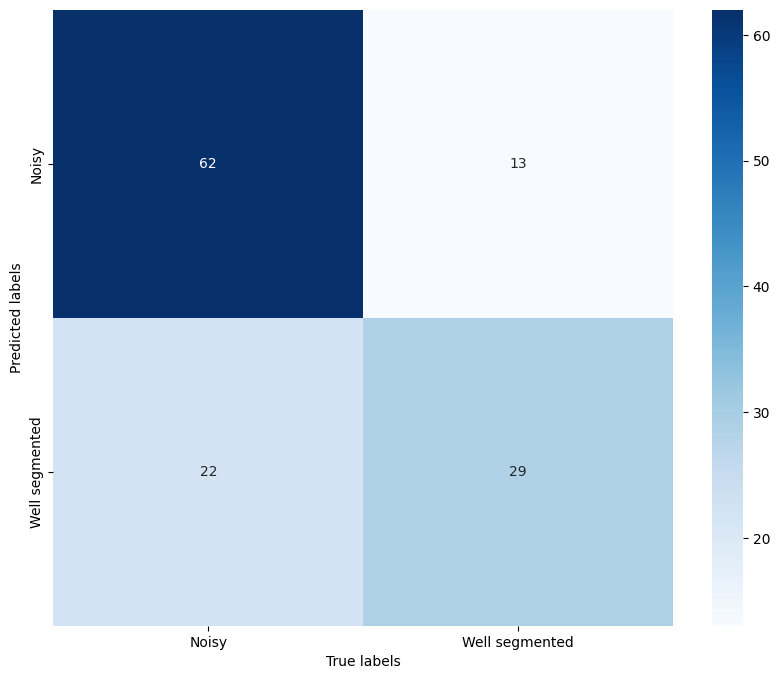

In [51]:
plot_cnn_prediction(model, X_test_classifier, y_test_classifier)

In [ ]:
# Format data for multi class classifier
def format_data_multiclass_classifier(X, y, y_bin, threshold=0.85):
  #print(X.shape, y.shape, y_bin.shape)
  num_zeros = np.size(y_bin) - np.count_nonzero(y_bin)
  print('Total imgs out from filter:', num_zeros)

  segmented_indices = [] 
  imgs = []
  masks = []
  labels = []
  for i, (img, label, label_bin) in enumerate(zip (X, y, y_bin)): 
    # Ok for segmentation task
    if int(label_bin) == 1:
      segmented_indices.append(i)
      continue

    # Ok for classification task
    unique, counts = np.unique(label, return_counts=True)
    f = False
    for u, c in zip(unique, counts):
      if c / TOT_PIXELS >= threshold: 
        labels.append(u)
        imgs.append(img)
        masks.append(label)
        f = True
        break
    if not f:
      raise RuntimeError('Should not be here')
  print(f'Total images discarded (well segmented): {len(segmented_indices)}') 
  return np.array(imgs), np.array(masks), np.array(labels), segmented_indices

In [53]:
X_train_multi_classifier, y_train_multi_classifier_mask, y_train_multi_classifier, seg_index_train = format_data_multiclass_classifier(X_train, y_train, y_train_classifier)
X_val_multi_classifier, y_val_multi_classifier_mask, y_val_multi_classifier, seg_index_val = format_data_multiclass_classifier(X_val, y_val, y_val_classifier)
X_test_multi_classifier, y_test_multi_classifier_mask, y_test_multi_classifier, seg_index_test = format_data_multiclass_classifier(X_test, y_test, y_test_classifier)

Total imgs out from filter: 1281
Total images discarded (well segmented): 852
Total imgs out from filter: 154
Total images discarded (well segmented): 92
Total imgs out from filter: 75
Total images discarded (well segmented): 51


[1. 1. 1. 2.]


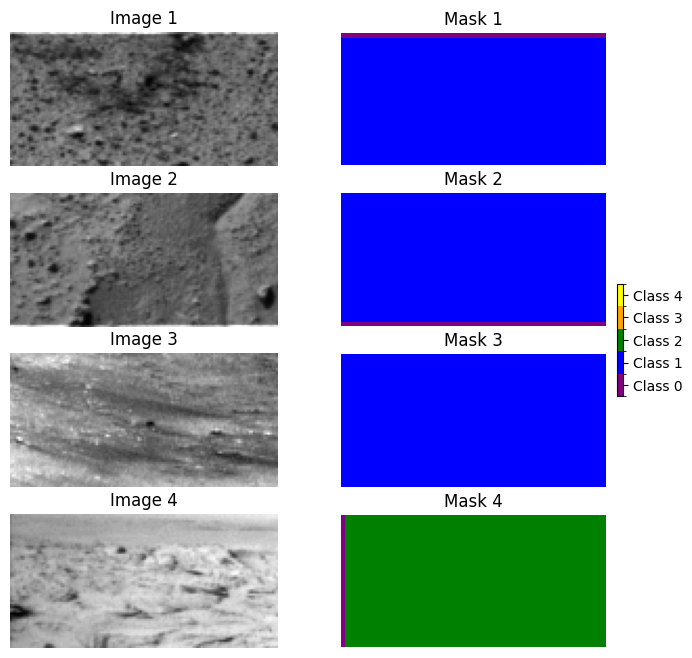

In [54]:
# Check labels
N = 4
print(y_train_multi_classifier[:N])
plot(X_train_multi_classifier, mask=y_train_multi_classifier_mask, num_images=N)

In [69]:
# We use 4 classes as the last class has no items
model_multi = build_classifier('cnn', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1), num_cls=4, augmentation=augmentation)

In [ ]:
# Define class weights and use them if needed
from sklearn.utils.class_weight import compute_class_weight

# Get unique elements and their counts
unique_elements, counts = np.unique(y_train_multi_classifier, return_counts=True)

# Print the results
for element, count in zip(unique_elements, counts):
    print(f"{element} freq = {count}")

# Make weights proportional to class imbalance
class_weight_dict_multi_classification = dict(enumerate(compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_multi_classifier), 
    y=np.ravel(y_train_multi_classifier)
)))
from pprint import pprint
print('Class weights:')
pprint(class_weight_dict_multi_classification)

0.0 freq = 184
1.0 freq = 584
2.0 freq = 279
3.0 freq = 234
Class weights:
{0: 1.7404891304347827,
 1: 0.5483732876712328,
 2: 1.1478494623655915,
 3: 1.3685897435897436}


In [ ]:
import keras_cv
model_multi.compile(optimizer=tfk.optimizers.AdamW(1e-3),
                         loss=keras_cv.losses.FocalLoss(label_smoothing=0.1),
                         metrics=['accuracy'])
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=30,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [ ]:
# Train the model with early stopping callback
history = model_multi.fit(
    x=X_train_multi_classifier,
    y=tfk.utils.to_categorical(y_train_multi_classifier),
    batch_size=classifier_batch_size,
    epochs=classifier_epochs,
    validation_data=(X_val_multi_classifier, tfk.utils.to_categorical(y_val_multi_classifier)),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 0.4000 - loss: 0.3667 - val_accuracy: 0.3766 - val_loss: 0.3718
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4523 - loss: 0.3487 - val_accuracy: 0.3766 - val_loss: 0.3611
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4575 - loss: 0.3401 - val_accuracy: 0.3961 - val_loss: 0.3391
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4683 - loss: 0.3252 - val_accuracy: 0.4740 - val_loss: 0.3246
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5028 - loss: 0.3158 - val_accuracy: 0.5260 - val_loss: 0.3045
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5456 - loss: 0.3052 - val_accuracy: 0.5714 - val_loss: 0.2950
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5626 - loss: 0.2983 - val_accuracy: 0.4805 - val_loss: 0.3177
Epoch 8/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5569 - loss: 0.3005 - val_accuracy: 0

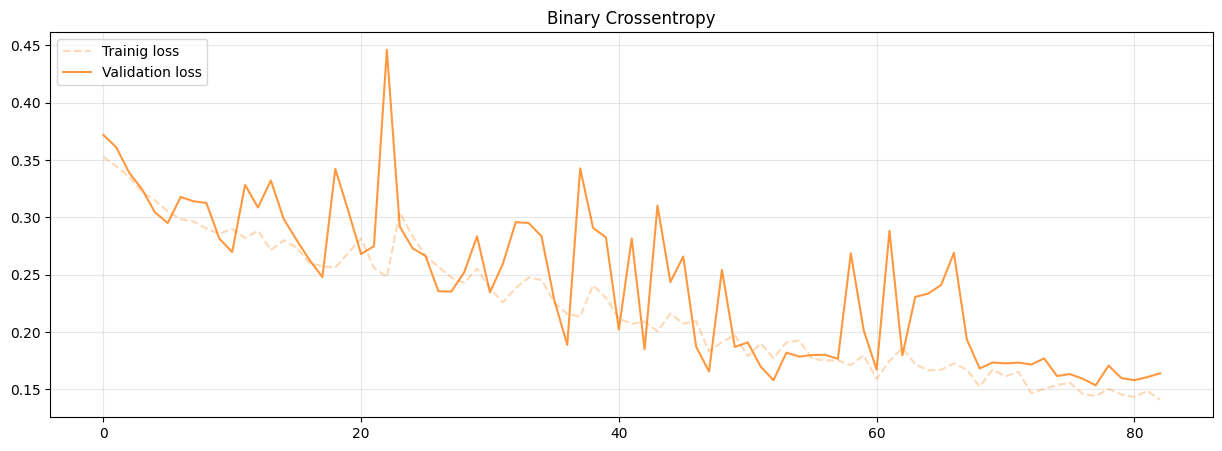

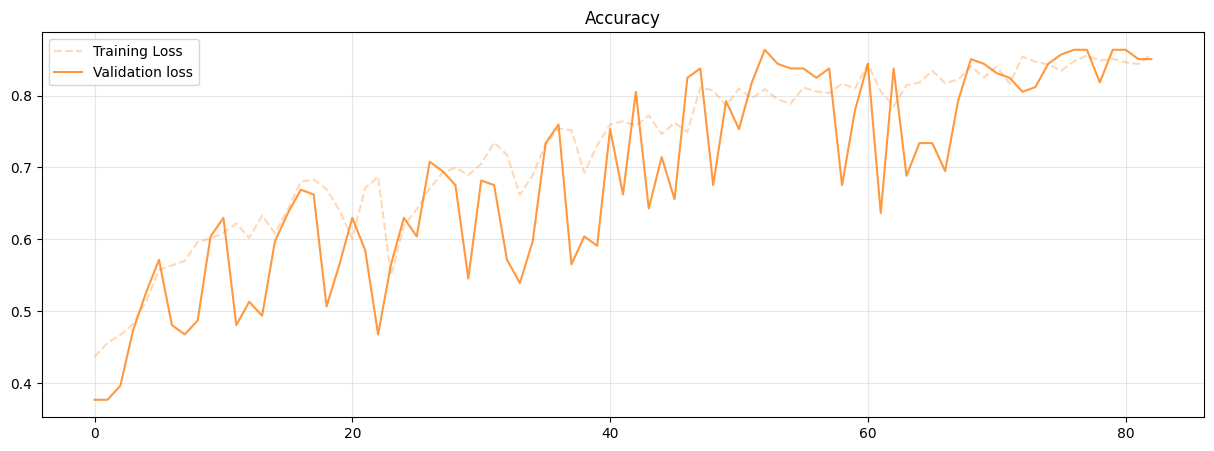

In [73]:
plot_cnn_training(history)

In [ ]:
labels = {
  0: "Background",
  1: "Soil",
  2: "Bedrock",
  3: "Sand",
}
def plot_cnn_multi_prediction(m, X, y):
  from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
  import seaborn as sns
  predictions = m.predict(X, verbose=1)
  print("Predictions Shape:", predictions.shape)
  pred_classes = np.argmax(predictions, axis=-1)
  true_classes = np.argmax(y, axis=-1)
  accuracy = accuracy_score(true_classes, pred_classes)
  print(f'Accuracy score over the test set: {round(100 * accuracy, 2)}%')
  precision = precision_score(true_classes, pred_classes, average='weighted')
  print(f'Precision score over the test set: {round(100 * precision, 2)}%')
  recall = recall_score(true_classes, pred_classes, average='weighted')
  print(f'Recall score over the test set: {round(100 * recall, 2)}%')
  f1 = f1_score(true_classes, pred_classes, average='weighted')
  print(f'F1 score over the test set: {round(100 * f1, 2)}%')
  cm = confusion_matrix(true_classes, pred_classes)
  cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
  annot = np.array([f"{num}\n({percent:.2f}%)" for num, percent in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm_percentage.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.title('Confusion Matrix (Percentages)')
  plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
Predictions Shape: (75, 4)
Accuracy score over the test set: 92.0%
Precision score over the test set: 92.01%
Recall score over the test set: 92.0%
F1 score over the test set: 91.92%


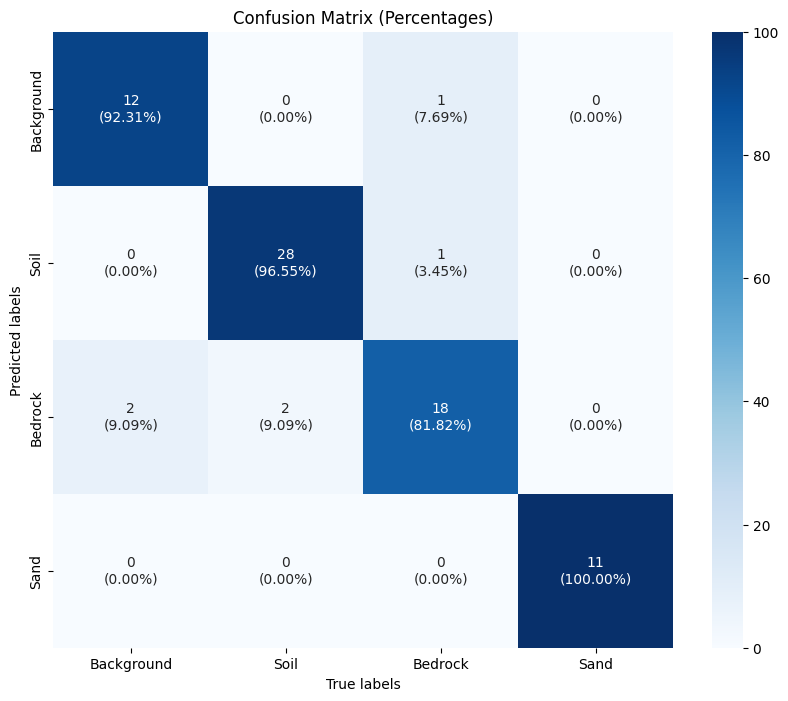

In [75]:
plot_cnn_multi_prediction(model_multi, X_test_multi_classifier, tfk.utils.to_categorical(y_test_multi_classifier))

In [ ]:
model_multi.save(f'multi-cnn{final_val_accuracy}.keras')

## 🧗🏻‍♂️ Train and save segmentation model

In [76]:
SEGMENTATION_WEIGHTS = 'ASPP-61.02-w.weights.h5'

In [ ]:
# Filter out dataset for segmentation task
X_train_seg = X_train[seg_index_train]
y_train_seg = y_train[seg_index_train]
X_val_seg = X_val[seg_index_val]
y_val_seg = y_val[seg_index_val]
X_test_seg = X_test[seg_index_test]
y_test_seg = y_test[seg_index_test]
print(f'Train shapes: {X_train_seg.shape} {y_train_seg.shape}')
print(f'Val shapes: {X_val_seg.shape} {y_val_seg.shape}')
print(f'Test shapes: {X_test_seg.shape} {y_test_seg.shape}')

In [ ]:
# Define custom Mean Intersection Over Union metric: the competition excludes the background class
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
  def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
    super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
    self.labels_to_exclude = labels_to_exclude

  def update_state(self, y_true, y_pred, sample_weight=None):
    # Convert predictions to class labels
    y_pred = tf.math.argmax(y_pred, axis=-1)

    # Flatten the tensors
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    # Apply mask to exclude specified labels
    for label in self.labels_to_exclude:
      mask = tf.not_equal(y_true, label)
      y_true = tf.boolean_mask(y_true, mask)
      y_pred = tf.boolean_mask(y_pred, mask)

    # Update the state
    return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
def plot_training(fit):
  # Plot and display training and validation loss
  plt.figure(figsize=(18, 3))
  plt.plot(fit['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
  plt.plot(fit['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
  plt.title('Cross Entropy')
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()

  # Plot and display training and validation accuracy
  plt.figure(figsize=(18, 3))
  plt.plot(fit['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
  plt.plot(fit['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
  plt.title('Accuracy')
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()

  # Plot and display training and validation mean IoU
  plt.figure(figsize=(18, 3))
  plt.plot(fit['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
  plt.plot(fit['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
  plt.title('Mean Intersection over Union')
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()

In [ ]:
def plot_triptychs(dataset, model, num_batches=1):
  """
  Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

  Parameters:
  dataset: tf.data.Dataset - The dataset containing image-label pairs
  model: tf.keras.Model - The trained model to generate predictions
  num_samples: int - Number of samples to plot
  """
  # Take samples from the dataset
  samples = dataset.take(num_batches)

  for images, labels in samples:
    # Generate predictions
    preds = model.predict(images, verbose=0)
    preds = tf.math.argmax(preds, axis=-1)

    # Create figure with subplots
    batch_size = images.shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))

    if batch_size == 1:
      axes = [axes]  # Handle case where batch size is 1

    # Define custom colors for each class
    import matplotlib.colors as mcolors
    class_colors = ["purple", "blue", "green", "orange", "yellow"]  # Define your colors
    cmap = mcolors.ListedColormap(class_colors)

    # Define normalization to map class values to the color map
    bounds = np.arange(num_classes + 1) - 0.5  # Create boundaries for each class
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    for i in range(batch_size):
      # Plot original image
      axes[i][0].set_title("Original Image")
      axes[i][0].imshow(images[i])
      axes[i][0].axis('off')

      # Plot original mask
      axes[i][1].set_title("Original Mask")
      axes[i][1].imshow(labels[i], cmap=cmap, norm=norm)
      axes[i][1].axis('off')

      # Plot predicted mask
      axes[i][2].set_title("Predicted Mask")
      axes[i][2].imshow(preds[i], cmap=cmap, norm=norm)
      axes[i][2].axis('off')

    # Add a colorbar
    cbar = fig.colorbar(
      plt.cm.ScalarMappable(cmap=cmap, norm=norm),
      ax=axes[:, 1],  # Align the colorbar with the mask columns
      orientation="vertical",
      fraction=0.02,
      pad=0.04
    )
    cbar.set_ticks(np.arange(num_classes))  # Set tick locations
    cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)])  # Set tick labels

    #plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
miou = MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])

if SEGMENTATION_WEIGHTS:
  model = model_dict[model_name](IMG_SIZE + (1,), NUM_CLASSES)
  model.load_weights(SEGMENTATION_WEIGHTS)
  model.compile(loss=get_loss(),
                optimizer=get_optimizer(batch_size=training_schedule[-1]['batch_size'], lr = training_schedule[-1]['lr'], opt=training_schedule[-1]['opt_name']), 
                metrics=['accuracy', miou])
elif not model_filename_override:
  model = model_dict[model_name](IMG_SIZE + (1,), NUM_CLASSES)
  histories = []

  for ts in training_schedule:
    model.compile(loss=get_loss(),
                  optimizer=get_optimizer(batch_size=ts['batch_size'], lr = ts['lr'], opt=ts['opt_name']), 
                  metrics=['accuracy', miou])
    display_model(model)
    val_data_loader = get_dataset(X_val, y_val, batch_size=ts['batch_size'])
    if ts['augmentation']:
      if ts.get('enlarge_dataset_with_custom_np_ds', False):
        # This example enlarges the images with a lot of bg labels (>=90%)
        bg_augmented_data = get_enlarged_dataset(noisy_images[0][0], noisy_images[0][1], build_augmentation_bg)
        # You can add additional data and then using additional_ds_concat=[bg_augmented_data, ...]
        data_loader = get_dataset(X_train, y_train, 
                                  batch_size=ts['batch_size'], 
                                  augmentations=apply_augmentation,
                                  augmentation_repetition=ts['augmentation_repetition'], 
                                  concat_and_shuffle_aug_with_no_aug=ts['include_non_augmented'], additional_ds_concat=[bg_augmented_data])
        print(f"Training with augmentation x{ts['augmentation_repetition']}, enlarge_dataset_with_custom_np_ds and {'none ' if not ts['include_non_augmented'] else ''}non-augmented data.")
      else:
        data_loader = get_dataset(X_train, y_train, 
                                  batch_size=ts['batch_size'], 
                                  augmentations=apply_augmentation,
                                  augmentation_repetition=ts['augmentation_repetition'], 
                                  concat_and_shuffle_aug_with_no_aug=ts['include_non_augmented'])
        print(f"Training with augmentation x{ts['augmentation_repetition']} and {'none ' if not ts['include_non_augmented'] else ''}non-augmented data.")
    else:
      data_loader = get_dataset(X_train, y_train, batch_size=ts['batch_size'])
      print(f'Fitting model without augmentation')
    fit_history = fit_model(model, 
                            data_loader=data_loader, 
                            validation_data_loader=val_data_loader,
                            epochs = ts['epochs'])
    histories.append(fit_history)

  # Calculate and print the final validation accuracy
  final_val_meanIoU = round(max(histories[-1]['val_mean_iou'])* 100, 2)
  print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

  # Save intermediate model
  model_filename = f'{model_name}-{str(final_val_meanIoU)}-{datetime.now().strftime("%y%m%d_%H%M")}.keras'
  model.save(model_filename)

  # Free memory by deleting the model instance
  if FREE_MODEL:
    del model

Using AdamW optimizer (weight decay = 0.004)


In [ ]:
model.save_weights(f'{model_name}-{final_val_meanIoU}')

In [ ]:
if not model_filename_override:
  for fit_history in histories:
    plot_training(fit_history)

In [ ]:
# Evaluate the segmentation model
test_dataset = get_dataset(X_test, y_test, batch_size=8)

if model_filename_override:
  model = tfk.models.load_model(model_filename_override, compile=False)
  model.compile(
    loss=get_loss(),
    optimizer=get_optimizer(),
    metrics=["accuracy", miou]
  )
  display_model(model)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=1)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 359ms/step - accuracy: 0.6673 - loss: 0.3352 - mean_iou: 0.6507
Test Accuracy: 0.6677
Test Mean Intersection over Union: 0.6239


In [86]:
plot_triptychs(test_dataset, model, num_batches=0)

2024-12-11 12:17:40.684707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 🥂 Combine model

In [101]:
binary_model = tf.keras.models.load_model('binary-cnn79.02.keras') 
multi_model = tf.keras.models.load_model('multi-cnn90.08.keras')
segmentation_model = model

In [280]:
SEG_SOURCE = 0
CLASS_SOURCE = 1
def combined_model(input_data: np.ndarray):
  res = []
  source = []
  prob_bin_model = []
  for i in input_data:
    # Add batch dimension
    i = tf.expand_dims(i, axis=0)  # Shape: (1, 64, 128, 1)
    binary_output = binary_model(i)
    binary_output = round(float(binary_output[0]), 2)
    prob_bin_model.append(binary_output)

    if binary_output > 0.1:
      seg_out = segmentation_model(i)
      res.append(seg_out[0])
      source.append(SEG_SOURCE)
    else:
      multi_out = multi_model(i)
      label = tf.argmax(multi_out, axis=-1)
      label = tf.fill((1, 64, 128), label)
      label = tf.one_hot(label, depth=5)
      res.append(label[0])
      source.append(CLASS_SOURCE)
  return np.array(res), source, prob_bin_model


In [285]:
N = X_test.shape[0]
preds, sources, probs = combined_model(X_test[:N])

In [286]:
# Plot the data. The number of images being displayed are rows X cols
def plot_combined_model(data=None, mask_true=None, mask_pred=None, sources=None, probs=None, num_images=10, num_cls=5, colors=None):
	# Define custom colors for each class
	import matplotlib.colors as mcolors
	class_colors = ["purple", "blue", "green", "orange", "yellow"] if colors is None else colors
	cmap = mcolors.ListedColormap(class_colors)
	bounds = np.arange(num_cls + 1) - 0.5  # Create boundaries for each class
	norm = mcolors.BoundaryNorm(bounds, cmap.N)

	# Plot settings
	fig, axes = plt.subplots(num_images, 3, figsize=(8, num_images * 2))

	for i in range(num_images):
		# Original image
		axes[i, 0].imshow(data[i], cmap="gray")
		axes[i, 0].set_title(f"Image {i+1}")
		axes[i, 0].axis("off")

		# Corresponding mask
		axes[i, 1].imshow(mask_true[i], cmap=cmap, norm=norm)  # Adjust cmap as needed
		axes[i, 1].set_title(f"Mask true {i+1}")
		axes[i, 1].axis("off")

		# Corresponding mask
		axes[i, 2].imshow(mask_pred[i], cmap=cmap, norm=norm)  # Adjust cmap as needed
		axes[i, 2].set_title(f"Mask pred {i+1} from source {'SEG' if sources[i] == SEG_SOURCE else 'CLASS'} p={probs[i]}")
		axes[i, 2].axis("off")

	# Add a colorbar
	cbar = fig.colorbar(
		plt.cm.ScalarMappable(cmap=cmap, norm=norm),
		ax=axes[:, 1],  # Align the colorbar with the mask columns
		orientation="vertical",
		fraction=0.02,
		pad=0.04
	)
	cbar.set_ticks(np.arange(num_cls))  # Set tick locations
	cbar.set_ticklabels([f"Class {i}" for i in range(num_cls)])  # Set tick labels

	plt.tight_layout()
	plt.show()

/var/folders/5w/z61drr6x4kzfb5n_v8gpvj600000gn/T/ipykernel_8699/1491655718.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


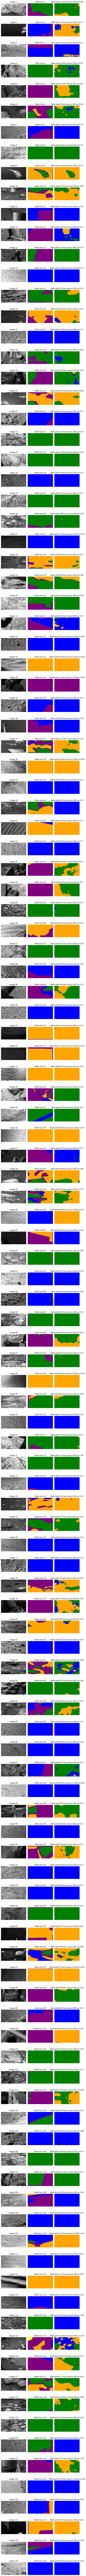

In [287]:
plot_combined_model(X_test[:N], y_test[:N], np.argmax(preds, axis=-1), sources, probs, num_images=N)

In [288]:
miou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])
miou.update_state(y_test[:N], preds)
miou.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.48675296>


## 🎰 Generate submission

We are not loading the model but using the python env model as there is a current error on the `MeanIntersectionOverUnion` class which is not serializable making the model not loadable

In [292]:
import pandas as pd

print(hidden_X_test.shape)
preds, sources, probs = combined_model(hidden_X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

def y_to_df(y) -> pd.DataFrame:
  """Converts segmentation predictions into a DataFrame format for Kaggle."""
  n_samples = len(y)
  y_flat = y.reshape(n_samples, -1)
  df = pd.DataFrame(y_flat)
  df["id"] = np.arange(n_samples)
  cols = ["id"] + [col for col in df.columns if col != "id"]
  return df[cols]

submission_filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M")}.csv'
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
print('Submission saved in', submission_filename)

(10022, 64, 128, 1)
Predictions shape: (10022, 64, 128)
Submission saved in submission_241211_1517.csv
